In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

from functools import partial

To generate Fisher Information stuff, we need a few steps:

- Specify the full pdf with all parameter choices.
- Pick one of those parameters.
- Pick a value for one of those parameters
- Generate samples with that value you fixed.
- Generate log f(xi|theta_pick) functions (where xi is generated from the distribution with theta_pick_0) 

In [2]:
def norm_var_partial(xi, mu, var):
    return ((xi - mu)**2)/(2*(var**2)) - 1/(2*var)

def norm_mu_partial(xi, mu, var):
    return (xi - mu)/var

def fisher_normal(mu_true,var_true,size):
    
    norm_var = norm(loc=mu_true,
                    scale=np.sqrt(var_true))
    
    xs = norm_var.rvs(size=size)
    
    loglik_mu = {}
    loglik_var = {}
    var_partials = {}
    mu_partials = {}
    
    def loglik(xi,mu,var):
        norm_var = norm(loc=mu,scale=np.sqrt(var))
        return norm_var.logpdf(xi)
    
    for i in range(size):
        loglik_mu[i] = partial(loglik, xi=xs[i],var=var_true)
        loglik_var[i] = partial(loglik, xi=xs[i],mu=mu_true)
        var_partials[i] = partial(norm_var_partial, xi=xs[i],mu=mu_true)
        mu_partials[i] = partial(norm_mu_partial, xi=xs[i],var=var_true)
        
    return loglik_mu, loglik_var, var_partials, mu_partials

def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
colors = ['royalblue', 'seagreen', 'indianred']

def plot_logliks(ax, logliks, theta_range, alpha=.25):
    
    theta_range_vals = [theta_range[ky]['mu'] for ky in theta_range]
    
    for ll in logliks.values():
        
        llvals = [ll(**theta_range[v]) for v in theta_range]
        ax.plot(theta_range_vals, llvals, alpha=alpha,color='sandybrown')
        
    remove_spines(ax)

def plot_logliks_wslopes(ax, logliks, partials, theta_evals, theta_range, step_size, which_slopes, alpha=.25):
    
    theta_range_vals = [theta_range[ky]['mu'] for ky in theta_range]
    
    color_index = {ky: i % 3 for i, ky in enumerate(theta_evals.keys())}
    
    for ll, pl, which in zip(logliks.values(), partials.values(), which_slopes):
        
        llvals = [ll(**theta_range[v]) for v in theta_range]
        ax.plot(theta_range_vals, llvals, alpha=alpha,color='sandybrown')
        
        if which:
            for ky, arg_dct in theta_evals.items():
                arg_name = list(arg_dct.keys())[0]
                ll_eval = ll(**arg_dct)
                slope = pl(**arg_dct)
                ll_change = step_size*slope
                eval_coor = (arg_dct[arg_name], ll_eval)
                left = (eval_coor[0]-step_size, eval_coor[1]-ll_change)
                right = (eval_coor[0]+step_size, eval_coor[1]+ll_change)
                color = colors[color_index[ky]]
                ax.plot([left[0],right[0]],[left[1],right[1]],'k-',color=color)
                ax.scatter(eval_coor[0],eval_coor[1],color=color)
                
    for ky, arg_dct in theta_evals.items():
        arg_name = list(arg_dct.keys())[0]
        color = colors[color_index[ky]]
        ax.axvline(x=arg_dct[arg_name],linestyle='--',color=color)
        
    remove_spines(ax)

def plot_partials(ax, partials, theta_evals, theta_range, which_slopes, alpha=.25):
    
    theta_range_vals = [theta_range[ky]['mu'] for ky in theta_range]
    
    color_index = {ky: i % 3 for i, ky in enumerate(theta_evals.keys())}
    
    for pl, which in zip(partials.values(), which_slopes):
        
        llvals = [pl(**theta_range[v]) for v in theta_range]
        ax.plot(theta_range_vals, llvals, alpha=alpha,color='sandybrown')
        
        if which:
            for ky, arg_dct in theta_evals.items():
                arg_name = list(arg_dct.keys())[0]
                slope = pl(**arg_dct)
                eval_coor = (arg_dct[arg_name], slope)
                color = colors[color_index[ky]]
                ax.scatter(eval_coor[0],eval_coor[1],color=color)
        
    for ky, arg_dct in theta_evals.items():
        arg_name = list(arg_dct.keys())[0]
        color = colors[color_index[ky]]
        ax.axvline(x=arg_dct[arg_name],linestyle='--',color=color)
        
    remove_spines(ax)
    
def plot_hist(ax, mu_partials, theta_eval, color,bins=20):
    
    vals = [lp(**theta_eval) for lp in mu_partials.values()]
    
    val_mean = np.mean(vals)
    val_std = np.std(vals)
    
    norm_var = norm(loc=val_mean,scale=np.sqrt(val_std))
    
    val_range = np.linspace(val_mean-val_std*5,val_mean+val_std*5,100)
    density = norm_var.pdf(val_range)
    
    ax.hist(vals, alpha=.6,color=color,normed=True, bins=bins)
    ax.plot(val_range,density, alpha=.6)
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    remove_spines(ax)
    

### What should the structure be?

- "A picture is worth alot"
- 

Outline of the answer:

- we care about $\frac{\partial}{\partial\theta}\log f(X|\theta)$ - why?
- It's expectation is zero
- Look at it's variance

# What is an intuitive explanation of the Fisher Information?

In this case, I find intuition will best be built with examples and visuals. Let's dive in.

## What does the Fisher Information accomplish?

Let's say a random variable $X$ and a parameter $\theta$ are related with some density function:

$p(X|\theta)$.

This could be a one-parameter distribution with a univariate output... or it could be a multidimensional, multiparameter distribution where all other values except $X$ and $\theta$ are fixed/known. The point is it could be *any* proper density function - just pretend we have its formula.

The Fisher Information answers the following question:

"How useful is the random variable $X$ in nailing down the unknown parameter $\theta$?"

So a random variable with a lot of information regarding $\theta$ will do a good job locating it's value with some set of observations. That's the *definition*.

### How does it accomplish that?

The focus of the Fisher information are on 'score' functions of observations ${x_1, x_2, \cdots, x_N}$ defined as:

$$
\textrm{score}_i(\theta) = \frac{\partial}{\partial \theta} \log p(x_i|\theta)
$$

To see why these are useful, let's focus on $\log p(x_i|\theta)$'s for two circumstances at either extreme of that which we care about: where $X$ is either really informative or uninformative regarding the location of $\theta$. Those will be:

1. Informative: $X$ is normally distributed with a known and small $\sigma^2$ of 1. The mean $\mu$ is our unknown $\theta$.
2. Uninformative: $X$ is normally distributed with a known and large $\sigma^2$ of 100.The mean $\mu$ is our unknown $\theta$ once again.

So we see:

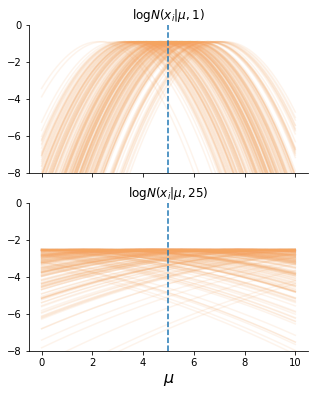

In [7]:
mu_true = 5
vars_true = [1,25]
alpha = .12
size = 200

fig, axarr = plt.subplots(2,1,sharex=True,sharey=True,figsize=(5,6))

all_mu_vals = np.linspace(mu_true-5,mu_true+5,200)
all_mu_vals = {i:{'mu':val} for i, val in enumerate(all_mu_vals)}

for i in range(2):
    loglik_mu, _, _, _ = fisher_normal(mu_true,vars_true[i],size)
    plot_logliks(axarr[i], loglik_mu, all_mu_vals, alpha=alpha)
    axarr[i].set_title(r'$\log N(x_i|\mu,{})$'.format(vars_true[i]))
    axarr[i].axvline(x=mu_true,linestyle='--')

axarr[1].set_xlabel(r'$\mu$',fontsize=16)
axarr[1].set_ylim(-8,0)
fig.savefig('logliksims.png',dpi=150)
pass

In effect, each curve is providing their own vote of the true parameter's location. Given that, isn't it obvious which implies a smaller range of that location? It's when these curves have a tighter peak, thereby restricting the range of possible $\mu$ values that could explain all such peaks.

So that right there is what the Fisher Information is after, but now the question becomes...

### How would we measure this?

It's done by looking at the score functions which give us the *slopes* of the curves above. To get a strong feel for these, 
let's take one of the above graphs and plot the derivative functions below it. Then, we'll pick a few $\mu$ values and evaluate slopes for those values, yielding a set of numbers for each. For each of these sets, we'll plot their histogram, giving us:

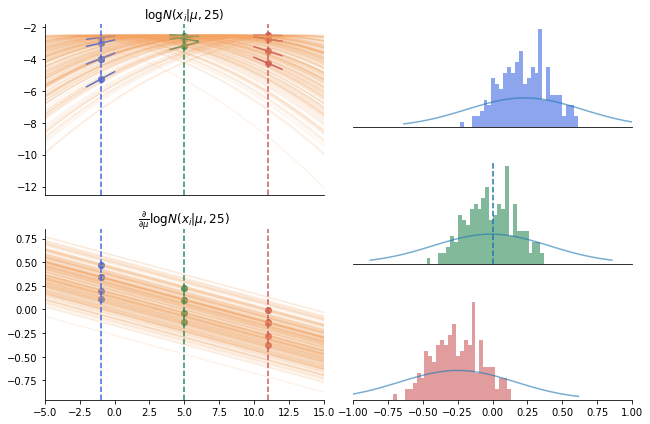

In [8]:
var_true = vars_true[1]
loglik_mu, loglik_var, var_partials, mu_partials = fisher_normal(mu_true,var_true,size)

all_mu_vals = np.linspace(mu_true-10,mu_true+10,100)
all_mu_vals = {i:{'mu':val} for i, val in enumerate(all_mu_vals)}

theta_evals = {0:{'mu':mu_true-6},
               1:{'mu':mu_true},
               2:{'mu':mu_true+6}}

which_slopes = np.random.uniform(size=len(loglik_mu)) < .05

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(ncols=2,nrows=6)

mu_lims = (-5,15)

ax = fig.add_subplot(gs[:3,0])
plot_logliks_wslopes(ax, loglik_mu, mu_partials, theta_evals, all_mu_vals, 1, which_slopes, alpha=alpha)
ax.set_xlim(mu_lims)
ax.set_xticks([])
ax.set_title(r'$\log N(x_i|\mu,{})$'.format(var_true))
ax = fig.add_subplot(gs[3:,0])
plot_partials(ax, mu_partials, theta_evals, all_mu_vals, which_slopes, alpha=alpha)
ax.set_xlim(mu_lims)
ax.set_title(r'$\frac{\partial}{\partial \mu}\log N(x_i|\mu,25)$')

for i in range(3):
    start=2*i
    ax = fig.add_subplot(gs[start:start+2,1])
    plot_hist(ax, mu_partials, theta_evals[i], colors[i],bins=30)
    ax.set_xlim(-1,1)
    if i < 2:
        ax.set_xticks([])
    if i == 1:
        ax.axvline(x=0,linestyle='--')

fig.tight_layout()
fig.savefig('partial_hist.png',dpi=150)

Now, imagine we squeezed the top left curves such that they become more peaked (and, as previously explained, our $X$ becomes more informative). What would happen? If it helps, look at the previous graph showing informative vs uninformative.

Well, as the curves become more peaked, the slopes *vary more widely*. That is, the histograms on the right become wider. This is the key insight! 

But before charging forward with this, there's one important observation here that generalizes nicely. That is, when our evaluation point for $\mu$ is the true $\mu$ (5 in the case), the mean of the slopes is zero (check out the middle histogram).This is written generally as:

$$
\mathbb{E}_{\theta^*}[\frac{\partial}{\partial\theta}\log p(X|\theta) \big|_{\theta=\theta^*}] = 0
$$

Sidebar on notation: I'm giving $\theta$ an asterisk to emphasize it's not exactly like our colored evaluation points in the graph. $\theta^*$ is both our evaluation point *and* the true parameter that generates $X$. Also, the subscript of $\theta^*$ next to the expectation sign means the expectation is calculated with $\theta^*$ as the parameter value.

Now I can tell you what the Fisher Informatiion is. It's the variance of the *middle* histogram. Written generally as:

$$
\mathcal{I}(\theta^*) = \textrm{var}_{\theta^*}(\frac{\partial}{\partial\theta}\log p(X|\theta) \big|_{\theta=\theta^*})
$$

One thing I have to remind myself is the two roles \theta^*

Because the expectation is zero, it simplifies further:

$$
\begin{align}
\mathcal{I}(\theta^*) & = \mathbb{E}_{\theta^*}\big[\big(\frac{\partial}{\partial\theta}\log p(X|\theta) \big|_{\theta=\theta^*}\big)^2\big]\\
\end{align}
$$

And it *turns out* (if $\log f(X|\theta)$ is twice differentiable) that:

$$
\mathbb{E}\big[\big(\frac{\partial}{\partial\theta}\log p(X|\theta) \big|_{\theta=\theta^*}\big)^2\big] = -\mathbb{E}\big[\frac{\partial^2}{\partial\theta^2}\log p(X|\theta) \big|_{\theta=\theta^*}\big]
$$

which isn't obvious, but not wholly unreasonable either. You expect a wide variance in your derivatives if your derivatives are changing a lot at that point. Derivatives that are changing a lot have a high absolute derivative themselves - a high second derivative!

So there you have it - the Fisher Information is the function $\mathcal{I}(\theta^*)$.

With the question answered, the conventional Quora wisdom would suggest I stop, but it's tempting to continue. With just a little bit more work, we can get a much more powerful form.

### The Multidimensional Fisher Information

The multidimensional case is a fairly seemless generalization of the 1D case. To do that, let's think carefully about our actions in the 1D case. The Fisher Information accepted one parameter value and returned a single number - a number which described the distribution of the log-likelihood derivatives. Hmm, so in the $D$-dimensional case, the Fisher Information should accept a length-$D$ parameter vector and return something that describes the distribution of the *gradient* (the multidimensional analogy of the derivative). The gradient is just vector. Let's think.. variance is to a scalar.. as a (something) is to a vector... oh, a covariance matrix! Easy! Our Fisher Information will accept a parameter vector and return a covariance matrix that describes the distribution of the log likelihood gradient. This naturally leads to this expression:

$$
\mathcal{I}(\boldsymbol{\theta}^*)_{i,j} = \mathbb{E}_{\boldsymbol{\theta}^*}\big[\big(\frac{\partial}{\partial\theta_i}\log p(X|\boldsymbol{\theta}) \big|_{\boldsymbol{\theta}=\boldsymbol{\theta}^*}\big)\big(\frac{\partial}{\partial\theta_j}\log p(X|\boldsymbol{\theta}) \big|_{\boldsymbol{\theta}=\boldsymbol{\theta}^*}\big)\big] 
$$

Here, $\mathcal{I}(\boldsymbol{\theta}^*)$ is the full covariance matrix. The cell in the $i$-th row and $j$-th column is the expected product of the $i$-th and $j$-th elements of the gradient. Since each of these will have an expectation of zero separately, their expected product is also their covariance.

Also, we get a similar 2nd derivative simplification as we saw earlier:

$$
\mathcal{I}(\boldsymbol{\theta}^*)_{i,j} = -\mathbb{E}_{\boldsymbol{\theta}^*}\big[\frac{\partial^2}{\partial\theta_i\partial\theta_j}\log p(X|\boldsymbol{\theta}) \big|_{\boldsymbol{\theta}=\boldsymbol{\theta}^*}\big] 
$$

You might recognize the Hessian matrix in there. So let's say it all together now. The covariance matrix of the log likelihood's gradient evaluated at the given parameter values and according to the distribution dictated by the those values... is the negative expected Hessian Matrix of the log likelihood. That's. awesome.

### Keep it intuitive!

To make this more concrete, let's imagine generalizing the example I gave earlier to the 2-parameter case (so now we consider both the mean and the variance, but our random variable is still a scalar). Those sampled score functions would no longer be 1D curves, but more like 2D domes. The histograms on the right would be 2D histograms. A vary spread out histogram would imply we could locate the true parameter vector quite well. A very spiked histogram would imply we see very similar gradients frequently and the lack of diverse information makes it hard to nail down the true parameter.

But we can take it a little further. A 2D histogram can be very spread out in one direction and very thin in the orthogonal direction. Well, our previous reasoning extrapolates well here. The spread out direction is the direction where we can easily determined the true value. Said differently, if we considered two parameter vectors along that direction, we could well identify which is more likely to be our true parameter. If two parameters fall along the thin direction, we can't.




### The Big-Kahuna

All this work has given us a measure of informative vs non-informative, but it hasn’t given us the distribution of the unknown parameter [2]. The reason is there’s no single solution in this general case. But we do have some luck *in the limit*.  

$$
\boldsymbol{\theta}_{MLE} \sim \mathcal{N}(\boldsymbol{\theta^*},\frac{1}{N}\mathcal{I}(\boldsymbol{\theta^*})^{-1})
$$


In [5]:
# mu_true = 15
# var_true = 25
# size = 20
# loglik_mu, loglik_var, var_partials, mu_partials = fisher_normal(mu_true,var_true,size)

# all_mu_vals = np.linspace(mu_true-10,mu_true+10,100)
# mu_eval = mu_true

# fig, ax = plt.subplots()

# slope_step = 2

# slopes = []

# for llmu, pmu in zip(loglik_mu.values(), mu_partials.values()):
#     llvals = [llmu(mu=v) for v in all_mu_vals]
#     ax.plot(all_mu_vals, llvals, alpha=.1,color='grey')
    
#     ll_mu_eval = llmu(mu=mu_eval)
    
#     slope = pmu(mu=mu_eval)
#     slopes.append(slope)
#     ll_change = slope_step*slope
#     left = (mu_eval-slope_step,ll_mu_eval-ll_change)
#     right = (mu_eval+slope_step,ll_mu_eval+ll_change)
    
#     ax.plot([left[0],right[0]],[left[1],right[1]],'k-',color='blue')

# ax.axvline(x=mu_eval,linestyle='--',alpha=.1,linewidth=1)

To make these feel real, let's follow this general routine:

1. Pick any distribution and set its parameter values to our liking.
3. Generate samples ${x_1, x_2, \cdots, x_N}$.
4. Designate one of the parameters as 'unknown'. That is, it'll be $\theta$ from the previous description.
5. Plot $\log p(x_i|\theta)$ vs $\theta$  for each sample.
6. Pick a point (or points) for $\theta$ (call it $\theta_0$) and check out the slopes at $\log p(x_i|\theta_0)$, which will be the set of values $\{\frac{\partial}{\partial \theta} \log p(x_i|\theta)\big|_{\theta=\theta_0}\}_i^N$.
7. In fact, plot $\frac{\partial}{\partial \theta} \log p(x_i|\theta)$ for each sample.
8. Doubly in fact, plot the histogram of our slopes $\{\frac{\partial}{\partial \theta} \log p(x_i|\theta)\big|_{\theta=\theta_0}\}_i^N$.

This will give us a good cross sectional view of our score functions.

I'll start with...

### The Normal Distribution

$X$ is normally distributioned with a $\mu$ of 15 and a $\sigma^2$ of 25. We'll generate 200 samples and proceed with the routine, giving us:

# What is an intuitive explanation of the Fisher Information?

The Fisher Information is a pretty badass concept, definitely deserving of an intuitive explanation. Ok, let's see what I can do.

## What's the goal of the Fisher Information?

Let's say a random variable $X$ and a parameter $\theta$ are related with the some density function:

$p(X|\theta)$.

This could be a one-parameter distribution with a univariate output... or it could be a multidimensional, multiparameter distribution where all other values except $X$ and $\theta$ are fixed. The point is it could be any proper density function - just pretend we have its formula.

The Fisher Information answers the following question:

"How useful is the random variable $X$ in nailing down the unknown parameter $\theta$?"

So a random variable with a lot of information regarding $\theta$ will do a good job locating it's value with some set of observations. That's the *definition* - got it?

### OK, how do we make progress?

To start us off, let's pretend we have a single observation $x_i$ sampled from $p(X|\theta_0)$ for some set but unknown parameter value $\theta_0$. How would you tell me if $x_i$ is useful in determining $\theta_0$? One idea is to check out the graph of $\theta$ vs $p(x_i|\theta)$. If it's very flat, changing $\theta$ doesn't impact the probability of $x_i$. If it has a clear peak, then by the principal of maximum likelihood, we have good evidence regarding the location of $\theta_0$.



# SCRAP

#### Attempt 1

You want an *intuitive* explanation? I think I have a recipe for that.

First, I'll layout the goal of the Fisher Information. Then, I'll arrive at the final form of the Fisher Information, but rather than rely on rigorous derivations, I'll rely on visuals. So instead of saying:

"it's true because of XYZ algebra"

I'll say:

"See, doesn't it *look* true?"

The hope is you'll finish this thinking the Fisher Information is as cool as I do.

### What's the goal of the Fisher Information?

It's purpose is to measure how well observations of a random variable X nail down the value of an unknown parameter $\theta$. 

To accomplish this goal, 

### Talk general

Let's say we have a random variable $X$, a parameter $\theta$ and their probability density function $f(X|\theta)$. Then I will simply *tell you* the following:

$$
\mathbb{E}_{\theta_0}[\frac{\partial}{\partial\theta}\log f(X|\theta) \big|_{\theta=\theta_0}] = 0
$$

for any given parameter value $\theta =\theta_0$. If the statement of the equation isn't clear, let me say it algorithmically:

1. Generated $N$ samples of $X$ from the distribution of $f(X|\theta_0)$, yielding the values ${x_1,x_2,\cdots,x_N}$.
2. Take an $x_i$ from this set and plug it into the log of our density function, yielding a function of $\theta$: $\log f(x_i|\theta)$.
3. Take the derivative of this function with respect to $\theta$, giving another function of $\theta$: $\frac{\partial}{\partial\theta}\log f(X|\theta)$ . 
4. Evaluate this at $\theta =\theta_0$ to produce a number for our $x_i$. 
5. Repeat this for all $N$ samples, yielding N numbers. 

As $N$ gets large, the average of these numbers approaches zero.

So that's the statement. If you want the derivation, it's right there on the wikipedia page (though I didn't find it illuminating).

What is illuminating is to *see* it.

### Get specific

Let's do that with the simplest possible case: the normal distribution. That is, let:

$$
X \sim \mathcal{N}(\mu,\sigma^2)
$$

Let's choose $\mu$ as our $\theta$ from above. Since we need to have the probability density as a function of only $X$ and $\mu$, we need to set $\sigma^2$, so let's go with $\sigma^2=25$.

Great, now I pick a value for $\mu$ ($\theta_0$ from above): $\mu=10$. Now I generate sam

### Attemp 2

You want an *intuitive* explanation? 

As usual, let's set up the problem. Let's say we have $D$ random variables whose distributions depends on $K$ parameters, written with some probability density as:

$$
p(X_1, X_2, \cdots, X_D\big|\theta_1,\theta_2, \cdots, \theta_K)
$$

(I'm writing it generally here, but pretend we have the formula for this).

Now I ask the question:

"How well do observations of $X_2$ (for example) inform me about $\theta_5$?"

Notice the question is fairly generic. It's not asking how well some specific values of $X_2$ determine $\theta_5$, but rather how useful $X_2$ is in general. Tricky right?

...

But their relationship is completely contained within $p(\cdots|\cdots)$, so it should be doable.

To kick off the explanation, let's pretend we have all other values except $X_2$ and $\theta_5$. We plug those into $p(\cdots|\cdots)$, giving a new function of just $X_2$ and $\theta_5$ (call it $g(X_2|\theta_5)$).




In [6]:
# class fisher():
    
#     dis_to_vars = {'Norm1D':('mu','var')}
#     vars_to_dis = {value:key for key, value in dis_to_vars.items()}
    
#     def __init__(self, param_dict):
#         self.param_dict = param_dict
#         if set(param_dict.keys()) == set(self.dis_to_vars['Norm1D']):
#             self.which = 'Norm1D'
#         else:
#             raise ValueError('Unrecognized Param Dict')
        
#     def gen_logf_funcs(self, size, **kwargs):
        
#         assert all([ky in self.dis_to_vars[self.which] for ky in kwargs.keys()]),'gen_logf_funcs received a bad argument'
        
#         params = self.param_dict.copy()
        
#         for ky in kwargs:
#             params[ky] = kwargs[ky]
            
#         if self.which == 'Norm1D':
            
#             norm_var = norm(loc=params['mu'],
#                             scale=np.sqrt(params['var']))
            
#             samples = norm_var.rvs(size=size)
            
#             def logf(sample, **param_vary_dict):
                    
#                     params_vary = params.copy()
                    
#                     for ky in param_vary_dict:
#                         params_vary[ky] = param_vary_dict[ky]
                        
#                     norm_var = norm(loc=params_vary['mu'],
#                                     scale=np.sqrt(params_vary['var']))
#                     return norm_var.logpdf(sample)
                
#             logf_funcs = {}
#             log_partials = {}
            
#             for i in range(size):
#                 logf_funcs[i] = partial(logf, sample=samples[i])
                
#             if set(kwargs.keys()) == 'mu':
                
                
            
                
            
                 
#         else:
#             pass
        
#         return logf_funcs
        
# params = {'mu':10,'var':10}
# ch = fisher(params)
# logf_funcs = ch.gen_logf_funcs(size=100, mu=10)

# fig, ax = plt.subplots()

# # thetas = np.linspace(2,5,100)

# for logf in logf_funcs.values():
#     vals = [logf(var=theta**2) for theta in thetas]
    
#     ax.plot(thetas,vals,alpha=.1,color='green')
    
# # ax.set_ylim(-10,10)
# # ax.set_xlim(5,15)
